In [1]:
import pandas as pd
import scipy.io
import re
import sys
import warnings
import pickle

In [2]:
from mvpa2.datasets.mri import fmri_dataset

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [3]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

Replicating earlier work on mvpa. Try not to overly complicate it--the main point is just to verify we get similar results on a different package to validate prior work. ANd we are primarily interested in validating the very high cross-validation results I got with nltools. Should aim for readable code.

In [4]:
from mvpa2 import *

In [5]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [6]:
brain_data_filepath = ml_data_folderpath + '/SST/Brain_Data_conditions_84subs_correct_cond.pkl'
results_filepath=ml_data_folderpath + "/SST/mvpa_tt_res_v3_conditions_84subs_twoclasses_pfcmask.pkl"

In [7]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [8]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [9]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [10]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

In [12]:
for kn in individual_differences.keys():
    print(kn +", " + str(type(individual_differences[kn])))
    print(individual_differences[kn].tolist())


subject, <class 'pandas.core.series.Series'>
['DEV001', 'DEV002', 'DEV004', 'DEV005', 'DEV006', 'DEV007', 'DEV008', 'DEV009', 'DEV010', 'DEV011', 'DEV012', 'DEV013', 'DEV014', 'DEV015', 'DEV016', 'DEV017', 'DEV018', 'DEV019', 'DEV020', 'DEV021', 'DEV022', 'DEV023', 'DEV024', 'DEV025', 'DEV026', 'DEV027', 'DEV028', 'DEV029', 'DEV030', 'DEV031', 'DEV032', 'DEV033', 'DEV034', 'DEV035', 'DEV036', 'DEV037', 'DEV038', 'DEV039', 'DEV040', 'DEV041', 'DEV042', 'DEV043', 'DEV044', 'DEV045', 'DEV046', 'DEV047', 'DEV048', 'DEV049', 'DEV050', 'DEV051', 'DEV052', 'DEV053', 'DEV054', 'DEV055', 'DEV056', 'DEV057', 'DEV058', 'DEV059', 'DEV060', 'DEV061', 'DEV062', 'DEV063', 'DEV064', 'DEV065', 'DEV066', 'DEV067', 'DEV068', 'DEV069', 'DEV070', 'DEV071', 'DEV072', 'DEV073', 'DEV074', 'DEV075', 'DEV076', 'DEV077', 'DEV078', 'DEV079', 'DEV080', 'DEV081', 'DEV082', 'DEV083', 'DEV084', 'DEV085', 'DEV086', 'DEV087', 'DEV088', 'DEV089', 'DEV090', 'DEV091', 'DEV093', 'DEV094', 'DEV095', 'DEV096', 'DEV097', 'DEV

In [13]:
import sys

sys.path.append(os.path.abspath("../../ml/"))

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [14]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

In [15]:
import mvpa2.datasets 

In [16]:
import nibabel as nib

In [17]:
from generic_utils import *

## masks

## now all the other masks

In [20]:
mask_list=get_all_masks(ml_data_folderpath)

In [21]:
mask_list

,mask_name,mask_filepath,thresh
0,planning_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
1,executive function_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
2,response inhibition_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
3,inhibition_association-test_z_FDR_0.01,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,0.1
4,harvardoxford-cortical_prob_Frontal Orbital Co...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
5,harvardoxford-cortical_prob_Inferior Frontal G...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0
6,harvardoxford-cortical_prob_Inferior Frontal G...,/gpfs/projects/sanlab/shared/DEV/nonbids_data/...,10.0


In [21]:
#mask_list = mask_list[mask_list.thresh==0.1]

In [22]:
for i, mr in mask_list.iterrows():
    print(mr['mask_name'])
    my_test_data =import_beta_series_pymvpa2(
        train_subjs_selected,'conditions',
        out_folder = ml_data_folderpath + "/SST/",
        conditions_to_include = ['CorrectGo','CorrectStop'],
        condition_count_required=2,
        supplementary_df = individual_differences,
        out_file_suffix = '_correct_cond_' + mr['mask_name'],
        beta_processing_args={
            'spatially_concatenate': False,
            'mask': mr['mask_filepath'],
            'masking_threshold': mr['thresh']
        }
    )

planning_association-test_z_FDR_0.01
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
 * Please note: warnings are printed only once, but underlying problem might occur many times *
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV005     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV005     1  
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1              

.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV024     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV024     1  
DEV025
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV025/SPM.mat
not enough conditions for subject DEV025. Skipping this subject.
DEV026
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV026/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV048     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV048     1  
DEV049
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV049/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV049     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV049     1  
DEV050
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV050/SPM.mat
.
.
...verifi

.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV069     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV069     1  
DEV071
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV071/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV071     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV071     1  
DEV073
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV135     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV135     1  
DEV141
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV141/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV141     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV141     1  
DEV145
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV145/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV217     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV217     1  
DEV218
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV218/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV218     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV218     1  
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_planning_associatio

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV022     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV022     1  
DEV023
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV023/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV023     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV023     1  
DEV024
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV024/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV046     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV046     1  
DEV047
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV047/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV047     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV047     1  
DEV048
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV048/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV067     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV067     1  
DEV068
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV068/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV068     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV068     1  
DEV069
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV069/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV105     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV105     1  
DEV107
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV107/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV107     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV107     1  
DEV135
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV135/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV215     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV215     1  
DEV216
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV216/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV216     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV216     1  
DEV217
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV217/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV020     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV020     1  
DEV021
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV021/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV021     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV021     1  
DEV022
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV022/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV042     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV042     1  
DEV043
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV043/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV043     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV043     1  
DEV046
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV046/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV062     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV062     1  
DEV064
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV064/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV064     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV064     1  
DEV067
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV067/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV089     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV089     1  
DEV097
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV097/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV097     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV097     1  
DEV105
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV105/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV197     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV197     1  
DEV206
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV206/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV206     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV206     1  
DEV215
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV215/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV018     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV018     1  
DEV019
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV019/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV019     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV019     1  
DEV020
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV020/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV040     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV040     1  
DEV041
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV041/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV041     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV041     1  
DEV042
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV042/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV059     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV059     1  
DEV060
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV060/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV060     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV060     1  
DEV062
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV062/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV086     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV086     1  
DEV087
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV087/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV087     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV087     1  
DEV089
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV089/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV177     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV177     1  
DEV186
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV186/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV186     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV186     1  
DEV197
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV197/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV016     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV016     1  
DEV017
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV017/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV017     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV017     1  
DEV018
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV018/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV036     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV036     1  
DEV039
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV039/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV039     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV039     1  
DEV040
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV040/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV057     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV057     1  
DEV058
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV058/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV058     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV058     1  
DEV059
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV059/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV084     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV084     1  
DEV085
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV085/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV085     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV085     1  
DEV086
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV086/SPM.mat
.
.
...verifi

.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV171     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV171     1  
DEV173
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV173/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV173     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV173     1  
DEV177
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV014     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV014     1  
DEV015
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV015/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV015     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV015     1  
DEV016
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV016/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV034     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV034     1  
DEV035
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV035/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV035     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV035     1  
DEV036
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV036/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV055     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV055     1  
DEV056
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV056/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV056     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV056     1  
DEV057
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV057/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV079     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV079     1  
DEV083
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV083/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV083     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV083     1  
DEV084
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV084/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV164     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV164     1  
DEV169
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV169/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV169     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV169     1  
DEV171
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV171/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV011     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV011     1  
DEV012
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV012/SPM.mat
not enough conditions for subject DEV012. Skipping this subject.
DEV013
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV013/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV013     1  
1  spm_spm:beta (0002) - Sn(

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV028     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV028     1  
DEV029
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV029/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV029     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV029     1  
DEV030
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV030/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV051     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV051     1  
DEV052
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV052/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV052     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV052     1  
DEV053
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV053/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV074     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV074     1  
DEV076
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV076/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV076     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV076     1  
DEV077
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV077/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV157     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV157     1  
DEV158
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV158/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV158     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV158     1  
DEV159
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV159/SPM.mat
.
.
...verifi

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/nilearn/_utils/niimg.py:61: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


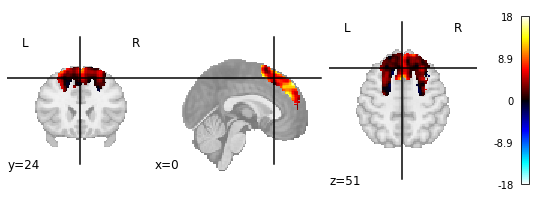

In [249]:
from nilearn import plotting
plotting.plot_stat_map(masked_nifti.slicer[...,0])


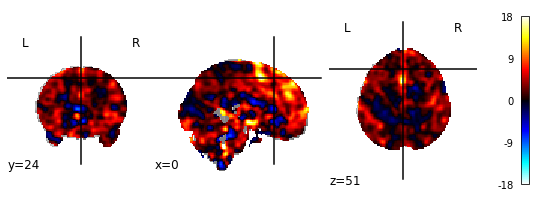

In [230]:
plotting.plot_stat_map(first_dataset_img,vmax=18,cut_coords = (0,24,51))

In [251]:
my_test_data =import_beta_series_pymvpa2(
        train_subjs_selected[0:2],'conditions',
        out_folder = ml_data_folderpath + "/SST/",
        conditions_to_include = ['CorrectGo','CorrectStop'],
        condition_count_required=2,
        supplementary_df = individual_differences,
        out_file_suffix = '_correct_cond_' + selected_mask['mask_name'],
        beta_processing_args={
            'spatially_concatenate': False,
            'mask': selected_mask['mask_filepath'],
            'masking_threshold': selected_mask['thresh']
        }
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
[[   2.    0.    0.  -96.]
 [   0.    2.    0. -132.]
 [   0.    0.    2.  -78.]
 [   0.    0.    0.    1.]]
[[  -1.    0.    0.   90.]
 [   0.    1.    0. -126.]
 [   0.    0.    1.  -72.]
 [   0.    0.    0.    1.]]
<class 'nibabel.nifti1.Nifti1Image'>
1072263, 9772,    condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV005     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV005     1  
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified

/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/scipy/ndimage/measurements.py:305: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


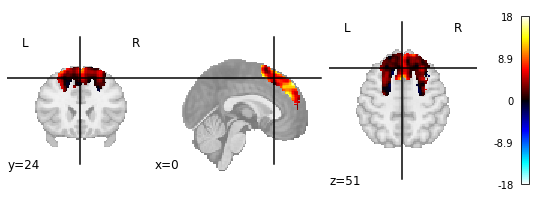

In [255]:
plotting.plot_stat_map(nilearn.masking.unmask(my_test_data.samples[0],my_test_data.a['mask_nifti'].value))


## contrasted stop Minus Go

In [28]:
for i, mr in mask_list.iterrows():
    print(mr['mask_name'])

    my_test_data =import_beta_series_pymvpa2(
        train_subjs_selected,'conditions',
        out_folder = ml_data_folderpath + "/SST/",
        conditions_to_include = ['CorrectGo','CorrectStop'],
        condition_count_required=2,
        supplementary_df = individual_differences,
        out_file_suffix = '_correct_stop_go_contrast_' + mr['mask_name'],
        beta_processing_args = {
            'contrast_condition_1':'CorrectStop',
            'contrast_condition_2':'CorrectGo',
            'spatially_concatenate':False,
            'mask': mr['mask_filepath'],
            'masking_threshold': mr['thresh']
        }
    )

planning_association-test_z_FDR_0.01
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV005     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV005     1  
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject 

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV024     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV024     1  
DEV025
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV025/SPM.mat
not enough conditions for subject DEV025. Skipping this subject.
DEV026
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV026/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV026     1  
1  spm_spm:beta (0002) - Sn(

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV048     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV048     1  
DEV049
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV049/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV049     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV049     1  
DEV050
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV050/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV069     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV069     1  
DEV071
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV071/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV071     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV071     1  
DEV073
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV073/SPM.mat
.
.
...verifi

.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV135     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV135     1  
DEV141
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV141/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV141     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV141     1  
DEV145
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV217     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV217     1  
DEV218
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV218/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV218     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV218     1  
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_stop_go_contrast_plannin

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV022     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV022     1  
DEV023
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV023/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV023     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV023     1  
DEV024
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV024/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV046     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV046     1  
DEV047
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV047/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV047     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV047     1  
DEV048
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV048/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV067     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV067     1  
DEV068
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV068/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV068     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV068     1  
DEV069
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV069/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV105     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV105     1  
DEV107
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV107/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV107     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV107     1  
DEV135
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV135/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV215     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV215     1  
DEV216
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV216/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV216     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV216     1  
DEV217
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV217/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV020     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV020     1  
DEV021
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV021/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV021     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV021     1  
DEV022
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV022/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV042     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV042     1  
DEV043
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV043/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV043     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV043     1  
DEV046
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV046/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV062     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV062     1  
DEV064
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV064/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV064     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV064     1  
DEV067
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV067/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV089     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV089     1  
DEV097
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV097/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV097     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV097     1  
DEV105
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV105/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV197     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV197     1  
DEV206
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV206/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV206     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV206     1  
DEV215
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV215/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV018     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV018     1  
DEV019
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV019/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV019     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV019     1  
DEV020
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV020/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV040     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV040     1  
DEV041
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV041/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV041     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV041     1  
DEV042
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV042/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV059     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV059     1  
DEV060
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV060/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV060     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV060     1  
DEV062
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV062/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV086     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV086     1  
DEV087
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV087/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV087     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV087     1  
DEV089
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV089/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV177     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV177     1  
DEV186
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV186/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV186     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV186     1  
DEV197
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV197/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV016     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV016     1  
DEV017
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV017/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV017     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV017     1  
DEV018
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV018/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV036     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV036     1  
DEV039
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV039/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV039     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV039     1  
DEV040
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV040/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV057     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV057     1  
DEV058
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV058/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV058     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV058     1  
DEV059
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV059/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV084     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV084     1  
DEV085
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV085/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV085     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV085     1  
DEV086
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV086/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV171     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV171     1  
DEV173
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV173/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV173     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV173     1  
DEV177
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV177/SPM.mat
.
.
...verifi

.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV014     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV014     1  
DEV015
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV015/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV015     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV015     1  
DEV016
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV034     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV034     1  
DEV035
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV035/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV035     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV035     1  
DEV036
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV036/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV055     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV055     1  
DEV056
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV056/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV056     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV056     1  
DEV057
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV057/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV079     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV079     1  
DEV083
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV083/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV083     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV083     1  
DEV084
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV084/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV164     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV164     1  
DEV169
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV169/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV169     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV169     1  
DEV171
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV171/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV011     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV011     1  
DEV012
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV012/SPM.mat
not enough conditions for subject DEV012. Skipping this subject.
DEV013
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV013/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV013     1  
1  spm_spm:beta (0002) - Sn(

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV028     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV028     1  
DEV029
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV029/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV029     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV029     1  
DEV030
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV030/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV051     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV051     1  
DEV052
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV052/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV052     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV052     1  
DEV053
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV053/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV074     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV074     1  
DEV076
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV076/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV076     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV076     1  
DEV077
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV077/SPM.mat
.
.
...verifi

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV157     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV157     1  
DEV158
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV158/SPM.mat
.
.
...verified that all expected betas exist! Processing...
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV158     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV158     1  
DEV159
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV159/SPM.mat
.
.
...verifi

In [19]:

my_test_data =import_beta_series_pymvpa2(
    train_subjs_selected,'conditions',
    out_folder = ml_data_folderpath + "/SST/",
    conditions_to_include = ['CorrectGo','CorrectStop'],
    condition_count_required=2,
    supplementary_df = individual_differences,
    out_file_suffix = '_correct_stop_go_contrast',
    beta_processing_args = {
        'contrast_condition_1':'CorrectStop',
        'contrast_condition_2':'CorrectGo',
        'spatially_concatenate':False,
        'mask': 'beta'
    }
)

/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/
DEV005
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV005/beta_0001.nii
 * Please note: warnings are printed only once, but underlying problem might occur many times *
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV005     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV005     1  
DEV006
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV006/SPM.mat
.
.
...verified th

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV020     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV020     1  
DEV021
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV021/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV021/beta_0001.nii
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV021     1  
1  spm_spm:beta (0002) - Sn(1)

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV036     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV036     1  
DEV039
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV039/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV039/beta_0001.nii
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV039     1  
1  spm_spm:beta (0002) - Sn(1)

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV052     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV052     1  
DEV053
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV053/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV053/beta_0001.nii
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV053     1  
1  spm_spm:beta (0002) - Sn(1)

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV069     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV069     1  
DEV071
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV071/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV071/beta_0001.nii
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV071     1  
1  spm_spm:beta (0002) - Sn(1)

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV089     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV089     1  
DEV097
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV097/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV097/beta_0001.nii
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV097     1  
1  spm_spm:beta (0002) - Sn(1)

   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV171     1  
1  spm_spm:beta (0002) - Sn(1) CorrectStop*bf(1)  beta_0002.nii  DEV171     1  
DEV173
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV173/SPM.mat
.
.
...verified that all expected betas exist! Processing...
setting the mask to the first image in the series beta_0001.nii
/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/fx/models/SST/wave1/conditions/sub-DEV173/beta_0001.nii
   condition_index condition_label  \
0                0       CorrectGo   
1                1     CorrectStop   

                            raw_beta_description           beta subject  wave  
0    spm_spm:beta (0001) - Sn(1) CorrectGo*bf(1)  beta_0001.nii  DEV173     1  
1  spm_spm:beta (0002) - Sn(1)